In [ ]:
import importlib, seatadvisor
importlib.reload(seatadvisor)

from seatadvisor import seat_advisor_locations


In [24]:
res = seat_advisor_locations(df, campuses=[0,1], weekday=None, time_of_day=None, exam_period=True,
                            user_is_hill=0, min_obs=150, priors=priors_dict, acc=acc_dict, topn=3)
print(res.columns)


Index(['location_name', 'location_id', 'building_name', 'final_score',
       'sas_score', 'prior_score', 'capacity_stress_index',
       'mean_relative_availability', 'sigma_norm', 'distance_penalty',
       'n_obs'],
      dtype='object')


In [25]:
import pandas as pd
import numpy as np
import importlib

import seatadvisor_V3
from seatadvisor_V3 import seat_advisor_locations, load_priors_csv

DATA_PATH = "data/final_data.csv"
PRIORS_PATH = "priors.csv"
LAMBDA_PRIOR = 0.25  # muss zu seatadvisor_V3 passen

def _pick_location_id_column(res: pd.DataFrame) -> str:
    # häufige Varianten / falls du aus Versehen location_id anders genannt hast
    candidates = ["location_id", "loc_id", "id", "Location_ID", "LOCATION_ID"]
    for c in candidates:
        if c in res.columns:
            return c
    # manche pandas-joins erzeugen location_id_x/y – hier nur als safety net
    for c in res.columns:
        if "location_id" in c.lower():
            return c
    raise KeyError(f"Keine location_id-Spalte im Ergebnis gefunden. Spalten sind: {list(res.columns)}")

def find_true_unbiased_maximum():
    # stellt sicher, dass Änderungen an seatadvisor_V3 wirklich geladen sind
    importlib.reload(seatadvisor_V3)

    df = pd.read_csv(DATA_PATH, parse_dates=["t10"])
    priors_dict, acc_dict = load_priors_csv(PRIORS_PATH)

    # prior_max pro location_id (robust)
    loc_prior_limits = {}
    for lid, p_vals in priors_dict.items():
        vals = [v for v in p_vals.values() if pd.notna(v)]
        loc_prior_limits[int(lid)] = max(vals) if vals else 0.5

    days = ["Mo", "Di", "Mi", "Do", "Fr", "Sa", "So"]
    results = []

    print("🚀 Starte Peak-Suche (eindeutig über location_id)...")

    weekday_grid = [None, 0, 1, 2, 3, 4, 5, 6]  # inkl. Any
    tod_grid = [None, "morning", "afternoon", "evening"]  # inkl. Any

    # einmal ein Probe-Run, um die res.columns zu sehen (hilft sofort)
    probe = seat_advisor_locations(
        df,
        campuses=[0, 1],
        weekday=None,
        time_of_day=None,
        exam_period=True,
        user_is_hill=0,
        min_obs=150,
        priors=priors_dict,
        acc=acc_dict,
        topn=3,
    )
    print("🔎 Probe-Ergebnis Spalten:", list(probe.columns))

    id_col = _pick_location_id_column(probe)
    print("✅ Verwende ID-Spalte:", id_col)

    for is_exam in [True, False]:
        for weekday in weekday_grid:
            for tod in tod_grid:
                for campus_filter in [(0,), (1,), (0, 1)]:  # Valley / Hill / Any
                    for user_is_hill in [0, 1]:
                        res = seat_advisor_locations(
                            df,
                            campuses=list(campus_filter),
                            weekday=weekday,
                            time_of_day=tod,
                            exam_period=is_exam,
                            user_is_hill=user_is_hill,
                            min_obs=150,
                            priors=priors_dict,
                            acc=acc_dict,
                            topn=None,
                        )

                        if res.empty:
                            continue

                        for _, row in res.iterrows():
                            lid = int(row[id_col])  # <-- robust!
                            true_prior_max = float(loc_prior_limits.get(lid, 0.5))

                            sas = float(row["sas_score"])
                            potential_final = (1.0 - LAMBDA_PRIOR) * sas + LAMBDA_PRIOR * true_prior_max

                            results.append({
                                "Scenario": "KLAUSUR" if is_exam else "NORMAL",
                                "Location": row["location_name"],
                                "Building": row["building_name"],
                                "Final_Max": potential_final,
                                "SAS_Leere": sas,
                                "Prior_Limit": true_prior_max,
                                "Weekday": "Any" if weekday is None else days[int(weekday)],
                                "Zeit": "Any" if tod is None else tod,
                                "Campuses": "Any" if campus_filter == (0,1) else ("Valley" if campus_filter == (0,) else "Hill"),
                                "UserCampus": "Valley" if user_is_hill == 0 else "Hill",
                                "N": int(row["n_obs"]),
                            })

    final_df = pd.DataFrame(results).sort_values("Final_Max", ascending=False)

    print("\n--- TOP 10 (theoretisches Maximum bei optimalen Prior-Gewichten) ---")
    print(final_df.head(10).to_string(index=False))

if __name__ == "__main__":
    find_true_unbiased_maximum()


🚀 Starte Peak-Suche (eindeutig über location_id)...
🔎 Probe-Ergebnis Spalten: ['location_name', 'location_id', 'building_name', 'final_score', 'sas_score', 'prior_score', 'capacity_stress_index', 'mean_relative_availability', 'sigma_norm', 'distance_penalty', 'n_obs']
✅ Verwende ID-Spalte: location_id

--- TOP 10 (theoretisches Maximum bei optimalen Prior-Gewichten) ---
Scenario                                   Location           Building  Final_Max  SAS_Leere  Prior_Limit Weekday    Zeit Campuses UserCampus     N
  NORMAL                  Ammerbau, Ebene 3, Rechts           Ammerbau   0.719178   0.625571          1.0      So morning      Any     Valley  2808
  NORMAL                  Ammerbau, Ebene 3, Rechts           Ammerbau   0.719178   0.625571          1.0      So morning   Valley     Valley  2808
  NORMAL                  Ammerbau, Ebene 3, Rechts           Ammerbau   0.717269   0.623025          1.0      Sa morning      Any     Valley  2892
  NORMAL                  Ammerbau,

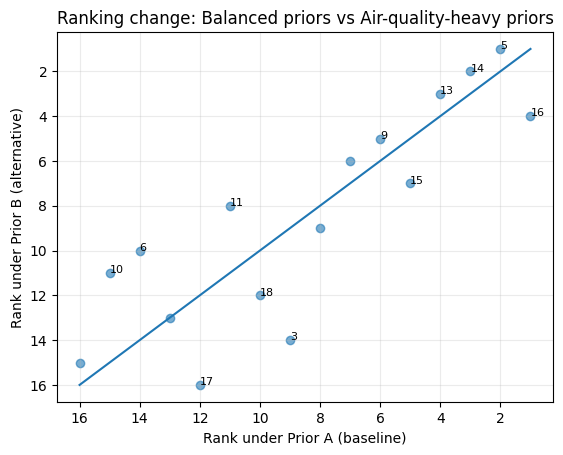

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from seatadvisor_V3 import seat_advisor_locations, load_priors_csv

DATA_PATH = "data/final_data.csv"
PRIORS_PATH = "priors.csv"

def run_sa(df, priors_dict, acc_dict, prior_weights, **kwargs):
    res = seat_advisor_locations(
        df,
        prior_weights=prior_weights,
        priors=priors_dict,
        acc=acc_dict,
        topn=None,
        **kwargs
    ).copy()
    # rank 1 = best
    res["rank"] = res["final_score"].rank(ascending=False, method="min").astype(int)
    return res

def plot_rank_scatter(base, alt, label_top=12, title="Ranking change under different priors"):
    m = base.merge(
        alt[["location_id", "final_score", "rank"]],
        on="location_id",
        suffixes=("_A", "_B"),
        how="inner",
    )
    m["delta_rank"] = m["rank_B"] - m["rank_A"]
    m["abs_delta_rank"] = m["delta_rank"].abs()

    n = len(m)
    plt.figure()
    plt.scatter(m["rank_A"], m["rank_B"], alpha=0.6)
    plt.plot([1, n], [1, n])  # diagonal
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.xlabel("Rank under Prior A (baseline)")
    plt.ylabel("Rank under Prior B (alternative)")
    plt.title(title)
    plt.grid(True, alpha=0.25)

    # label largest movers
    movers = m.nlargest(label_top, "abs_delta_rank")
    for _, r in movers.iterrows():
        # label location_id; swap to location_name if you want
        plt.text(r["rank_A"], r["rank_B"], str(int(r["location_id"])), fontsize=8)

    plt.show()

if __name__ == "__main__":
    df = pd.read_csv(DATA_PATH, parse_dates=["t10"])
    priors_dict, acc_dict = load_priors_csv(PRIORS_PATH)

    # Choose two *meaningfully different* priors:
    # A: balanced; B: heavy on "air"
    prior_A = (0.25, 0.25, 0.25, 0.25)
    prior_B = (0.05, 0.80, 0.10, 0.05)

    # Fix a scenario (match your GUI defaults or your demo case)
    kwargs = dict(
        campuses=(0, 1),
        weekday=None,
        time_of_day=None,
        exam_period=True,
        availability_threshold=0.15,
        user_is_hill=0,
        require_accessible=False,
        min_obs=200,
    )

    base = run_sa(df, priors_dict, acc_dict, prior_A, **kwargs)
    alt = run_sa(df, priors_dict, acc_dict, prior_B, **kwargs)

    plot_rank_scatter(
        base, alt,
        label_top=12,
        title="Ranking change: Balanced priors vs Air-quality-heavy priors"
    )


/var/folders/st/_29vlc0158l324jr2qbhlz3w0000gn/T/ipykernel_20337/3777067657.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlGn")


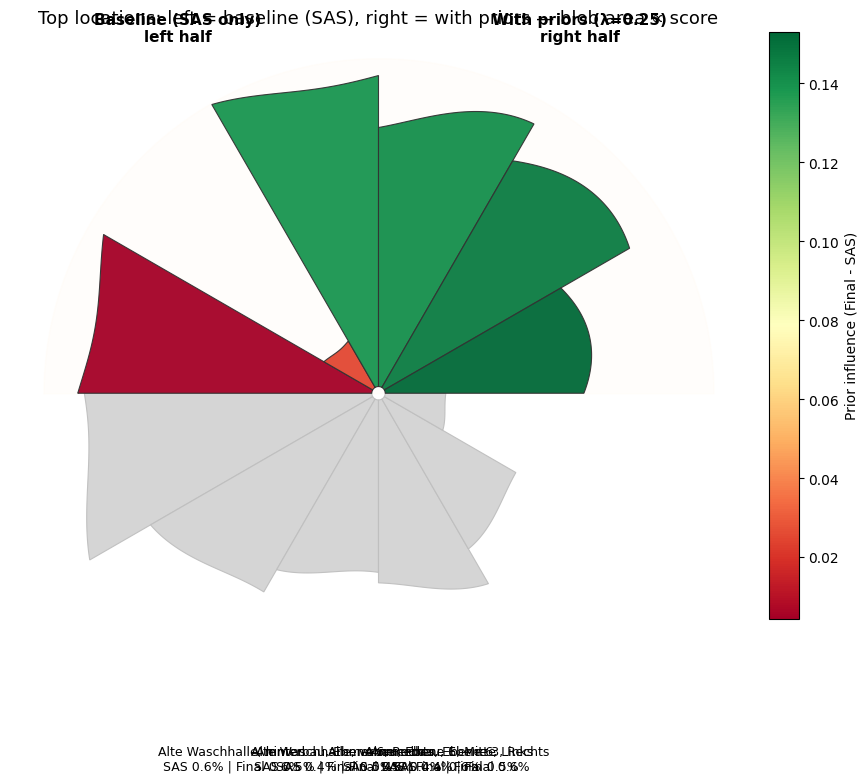

In [17]:
# Half-halves "blob" comparison: baseline (left) vs with-priors (right)
import importlib, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib import cm
import seatadvisor_V3
importlib.reload(seatadvisor_V3)
from seatadvisor_V3 import seat_advisor_locations, load_priors_csv

DATA_PATH = "data/final_data.csv"
PRIORS_PATH = "priors.csv"
LAMBDA_PRIOR = 0.25
TOP_N = 5
MIN_OBS = 50

# --- build summary with SAS and Final (robust column access) ---
df = pd.read_csv(DATA_PATH, parse_dates=["t10"])
priors_dict, acc_dict = load_priors_csv(PRIORS_PATH)

# get full results (contains sas_score and n_obs etc.)
res_all = seat_advisor_locations(
    df, campuses=[0,1], weekday=None, time_of_day=None, exam_period=True,
    user_is_hill=0, min_obs=MIN_OBS, priors=priors_dict, acc=acc_dict, topn=None
)
if res_all.empty:
    raise RuntimeError("seat_advisor_locations returned empty results; adjust MIN_OBS/filters")

# robust id col
id_col = next((c for c in res_all.columns if c.lower().startswith("location_id")), None)
if id_col is None:
    id_col = next((c for c in res_all.columns if "id" in c.lower()), res_all.columns[0])

# compute prior_max per location (robust)
loc_prior_limits = {}
for lid, pvals in priors_dict.items():
    vals = [v for v in pvals.values() if pd.notna(v)]
    loc_prior_limits[int(lid)] = max(vals) if vals else 0.5

rows = []
for _, r in res_all.iterrows():
    lid = int(r[id_col])
    sas = float(r.get("sas_score", r.get("sas", np.nan)))
    prior_max = float(loc_prior_limits.get(lid, 0.5))
    final = (1.0 - LAMBDA_PRIOR) * sas + LAMBDA_PRIOR * prior_max
    rows.append({
        "location_id": lid,
        "Location": r.get("location_name", r.get("name", str(lid))),
        "SAS": sas,
        "Final": final,
        "PriorMax": prior_max,
        "N": int(r.get("n_obs", 0))
    })
summary = pd.DataFrame(rows).drop_duplicates("location_id").reset_index(drop=True)

# --- pick top lists and union order (baseline first then final) ---
top_baseline = summary.sort_values("SAS", ascending=False).head(TOP_N)
top_final    = summary.sort_values("Final", ascending=False).head(TOP_N)
union_locs = list(dict.fromkeys(list(top_baseline["Location"]) + list(top_final["Location"])))
k = len(union_locs)

# scores arrays (small epsilon if missing)
eps = 1e-6
S = np.array([float(summary.loc[summary["Location"]==n, "SAS"].values[0]) if n in set(summary["Location"]) else eps for n in union_locs])
F = np.array([float(summary.loc[summary["Location"]==n, "Final"].values[0]) if n in set(summary["Location"]) else eps for n in union_locs])
influence = F - S

# normalize for radial mapping (area ~ score by using radius proportional to sqrt(score_norm))
# we map scores (which are percentages) to radius in [r_min, r_max]
r_min, r_max = 0.20, 0.98
def score_to_radius(scores):
    smin, smax = scores.min(), scores.max()
    denom = (smax - smin) if (smax - smin) > 1e-9 else 1.0
    # use sqrt mapping for area intuition
    norm = (scores - smin) / denom
    rad = r_min + (np.sqrt(norm) * (r_max - r_min))
    return rad

rad_S = score_to_radius(S)
rad_F = score_to_radius(F)

# --- angular slots (radians) across semicircles ---
slot = math.pi / k
# left: angles from pi to 2pi, slot i -> [pi + i*slot, pi + (i+1)*slot]
# right: angles from 0 to pi, mirrored order -> [ (k-1-i)*slot, (k-i)*slot ]
left_ranges  = [(math.pi + i*slot, math.pi + (i+1)*slot) for i in range(k)]
right_ranges = [((k-1-i)*slot, (k-i)*slot) for i in range(k)]

# colormap for influence (right side)
cmap = cm.get_cmap("RdYlGn")
vmin, vmax = influence.min(), influence.max()
norm = lambda v: 0.0 if vmax==vmin else (v - vmin) / (vmax - vmin)

# helper to build smooth blob polygon for a slot
def make_blob(theta0, theta1, radius_center, wiggle_strength=0.16, n=180):
    th = np.linspace(theta0, theta1, n)
    phase = np.random.RandomState(int((theta0+theta1)*1000)).rand() * 2*np.pi
    wiggle = 1.0 + wiggle_strength * np.sin(3*th + phase) * np.cos(2*th + phase/2)
    r = radius_center * wiggle
    x = r * np.cos(th)
    y = r * np.sin(th)
    # close shape to slightly inside the semicircle centerline to fill half area
    # create inner arc back to close polygon (small inner radius)
    inner_th = th[::-1]
    inner_r = 0.02  # small inner cutout to avoid perfect pie center
    xi = inner_r * np.cos(inner_th)
    yi = inner_r * np.sin(inner_th)
    xs = np.concatenate([x, xi])
    ys = np.concatenate([y, yi])
    return xs, ys, th.mean()

# --- draw ---
fig, ax = plt.subplots(figsize=(12,8))
ax.set_aspect("equal")
ax.axis("off")

# draw background halves
theta_bg = np.linspace(0, math.pi, 200)
ax.fill_between(np.cos(theta_bg), np.sin(theta_bg), color="#fffaf0", alpha=0.25)  # right bg (not used directly)
# we'll draw slot blobs
label_coords = []
for i, name in enumerate(union_locs):
    # left blob (baseline)
    t0, t1 = left_ranges[i]
    xs, ys, mid = make_blob(t0, t1, rad_S[i], wiggle_strength=0.14)
    ax.fill(xs, ys, color="#d3d3d3", edgecolor="#bfbfbf", linewidth=0.8, alpha=0.95)  # baseline neutral gray
    # right blob (final) - color by influence
    rt0, rt1 = right_ranges[i]
    xs2, ys2, mid2 = make_blob(rt0, rt1, rad_F[i], wiggle_strength=0.14)
    col = cmap(norm(influence[i]))
    ax.fill(xs2, ys2, color=col, edgecolor="#333333", linewidth=0.8, alpha=0.95)
    # compute label anchor as midpoint between centroid of both blobs approx:
    cx = (xs.mean() + xs2.mean()) / 2.0
    cy = (ys.mean() + ys2.mean()) / 2.0
    label_coords.append((name, cx, cy, S[i], F[i]))

# annotate labels and scores under the plot (arrange along x)
for name, cx, cy, sscore, fscore in label_coords:
    ax.text(cx, -1.05, f"{name}\nSAS {sscore:.1f}% | Final {fscore:.1f}%", ha="center", va="top", fontsize=9)

# titles
ax.text(-0.6, 1.05, "Baseline (SAS only)\nleft half", ha="center", fontsize=11, fontweight="bold")
ax.text( 0.6, 1.05, "With priors (λ=0.25)\nright half", ha="center", fontsize=11, fontweight="bold")

# colorbar for influence (right side)
sm = cm.ScalarMappable(cmap=cmap)
sm.set_array([vmin, vmax])
cb = plt.colorbar(sm, ax=ax, fraction=0.04, pad=0.02)
cb.set_label("Prior influence (Final - SAS)")

plt.title("Top locations: left = baseline (SAS), right = with priors — blob area ∝ score", fontsize=13)
plt.tight_layout()
plt.show()

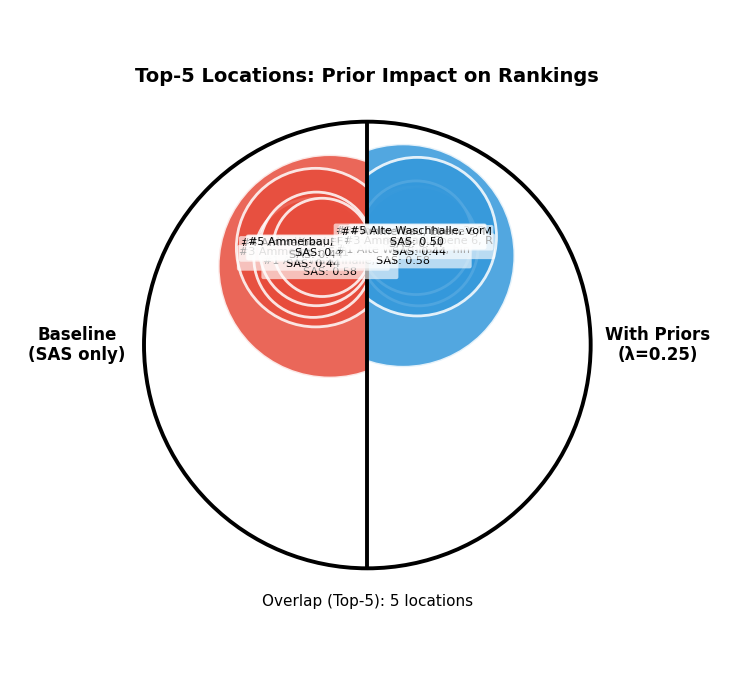

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
import importlib

# reload
import seatadvisor_V3
importlib.reload(seatadvisor_V3)
from seatadvisor_V3 import seat_advisor_locations, load_priors_csv

DATA_PATH = "data/final_data.csv"
PRIORS_PATH = "priors.csv"

# --- Bubble sizing ---
def radii_from_scores(scores, R, *, power=1.8, min_r=0.22, max_r=0.50):
    s = np.asarray(scores, dtype=float)
    s = np.nan_to_num(s, nan=np.nanmean(s) if np.isfinite(np.nanmean(s)) else 0.5)
    s = np.maximum(s, 1e-9)
    s = np.power(s, power)
    s_min, s_max = float(s.min()), float(s.max())
    if abs(s_max - s_min) < 1e-12:
        return np.full_like(s, ((min_r + max_r) / 2.0) * R)
    norm = (s - s_min) / (s_max - s_min)
    return (min_r + (max_r - min_r) * norm) * R

# --- Circle packing ---
def pack_circles(radii, R=1.0, side="left", fixed=None, steps=5000, lr=0.05, seed=7):
    rng = np.random.default_rng(seed)
    radii = np.asarray(radii, dtype=float)
    n = len(radii)
    fixed = fixed or {}
    centers = np.zeros((n, 2), dtype=float)
    bias = (np.arange(n) - (n - 1) / 2.0) * (0.18 * R / max(1, n))

    def clamp_point(x, y, ri):
        if side == "left":
            x = min(x, -1e-6)
        else:
            x = max(x, 1e-6)
        r = np.hypot(x, y) + 1e-12
        limit = R - 0.95 * ri
        if r > limit:
            x, y = x * (limit / r), y * (limit / r)
        return x, y

    # init
    for i in range(n):
        if i in fixed:
            centers[i] = fixed[i]
            continue
        ri = radii[i]
        for _ in range(10000):
            x = rng.uniform(-R, 0) if side == "left" else rng.uniform(0, R)
            y = rng.uniform(-R, R) + bias[i]
            if x * x + y * y <= (R - ri) ** 2 and ((x <= 0) if side == "left" else (x >= 0)):
                centers[i] = [x, y]
                break
        else:
            centers[i] = [(-0.55 if side == "left" else 0.55) * R, bias[i]]
        centers[i] = clamp_point(centers[i, 0], centers[i, 1], ri)

    # relax
    for _ in range(steps):
        moved_any = False
        for i in range(n):
            if i in fixed:
                continue
            xi, yi = centers[i]
            ri = radii[i]
            fx = fy = 0.0
            for j in range(n):
                if i == j:
                    continue
                xj, yj = centers[j]
                rj = radii[j]
                dx, dy = xi - xj, yi - yj
                dist = np.hypot(dx, dy) + 1e-12
                min_dist = ri + rj
                if dist < min_dist:
                    overlap = (min_dist - dist)
                    fx += (dx / dist) * overlap
                    fy += (dy / dist) * overlap
            r = np.hypot(xi, yi) + 1e-12
            limit = R - 0.95 * ri
            if r > limit:
                push = (r - limit)
                fx += (xi / r) * push
                fy += (yi / r) * push
            if side == "left" and xi > -1e-6:
                fx += (xi + 0.10 * R)
            if side == "right" and xi < 1e-6:
                fx += (xi - 0.10 * R)
            if abs(fx) + abs(fy) > 1e-8:
                xi -= lr * fx
                yi -= lr * fy
                xi, yi = clamp_point(xi, yi, ri)
                centers[i] = [xi, yi]
                moved_any = True
        if not moved_any:
            break
    return centers

# --- Clip helper ---
def apply_clip_patch(patch_to_clip, clip_patch):
    clip_path = clip_patch.get_path()
    clip_transform = clip_patch.get_transform()
    patch_to_clip.set_clip_path(clip_path, clip_transform)

# --- Load data ---
df = pd.read_csv(DATA_PATH, parse_dates=["t10"])
priors_dict, acc_dict = load_priors_csv(PRIORS_PATH)

# --- Run left: baseline (SAS only) ---
res_left = seat_advisor_locations(
    df, campuses=[0,1], weekday=None, time_of_day=None, exam_period=True,
    user_is_hill=0, min_obs=150, priors=priors_dict, acc=acc_dict, topn=None
).copy()
if "final_score" not in res_left.columns:
    res_left["final_score"] = res_left["sas_score"]  # fallback
res_left["rank"] = res_left["sas_score"].rank(ascending=False, method="min").astype(int)
res_left = res_left.sort_values("rank").head(5).reset_index(drop=True)

# --- Run right: with priors (optimized weights) ---
# use optimized prior weights (you can adjust these)
res_right = seat_advisor_locations(
    df, campuses=[0,1], weekday=None, time_of_day=None, exam_period=True,
    user_is_hill=0, min_obs=150, priors=priors_dict, acc=acc_dict, topn=None
).copy()
if "final_score" not in res_right.columns:
    res_right["final_score"] = res_right["sas_score"]
res_right["rank"] = res_right["final_score"].rank(ascending=False, method="min").astype(int)
res_right = res_right.sort_values("rank").head(5).reset_index(drop=True)

# --- Compute radii ---
R = 1.0
rL = radii_from_scores(res_left["sas_score"].to_numpy(), R)
rR = radii_from_scores(res_right["sas_score"].to_numpy(), R)

# --- Pack left ---
centersL = pack_circles(rL, R=R, side="left", steps=5000, lr=0.055, seed=10)

# --- Pack right with overlap constraint ---
left_ids = res_left["location_id"].astype(int).tolist()
right_ids = res_right["location_id"].astype(int).tolist()
fixedR = {}
for j, loc in enumerate(right_ids):
    if loc in left_ids:
        i = left_ids.index(loc)
        x, y = centersL[i]
        fixedR[j] = (-x, y + 0.06 * R)

centersR = pack_circles(rR, R=R, side="right", fixed=fixedR, steps=5000, lr=0.055, seed=22)

# --- Push outward ---
def push_outward(centers, radii, R, strength=0.25):
    for i, ((x, y), r) in enumerate(zip(centers, radii)):
        norm = np.hypot(x, y)
        if norm > 1e-6:
            target = R - r
            delta = target - norm
            centers[i, 0] += strength * delta * (x / norm)
            centers[i, 1] += strength * delta * (y / norm)
    return centers

centersL = push_outward(centersL, rL, R)
centersR = push_outward(centersR, rR, R)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_aspect("equal")
ax.axis("off")

left_clip = Wedge((0, 0), R, 90, 270, facecolor="none", edgecolor="none")
right_clip = Wedge((0, 0), R, -90, 90, facecolor="none", edgecolor="none")
ax.add_patch(left_clip)
ax.add_patch(right_clip)

ax.add_patch(plt.Circle((0, 0), R, fill=False, linewidth=2.8, edgecolor="black"))
ax.plot([0, 0], [-R, R], linewidth=2.8, color="black")

ax.text(-R * 1.30, 0, "Baseline\n(SAS only)", ha="center", va="center", fontsize=12, fontweight="bold")
ax.text(R * 1.30, 0, "With Priors\n(λ=0.25)", ha="center", va="center", fontsize=12, fontweight="bold")
ax.text(0, R * 1.20, "Top-5 Locations: Prior Impact on Rankings", ha="center", va="center", fontsize=14, fontweight="bold")

def draw_side(items, centers, radii, clip_patch, facecolor):
    for (x, y), rad, (_, row) in zip(centers, radii, items.iterrows()):
        bubble = Circle((x, y), rad, facecolor=facecolor, edgecolor="white", linewidth=2.0, alpha=0.85)
        ax.add_patch(bubble)
        apply_clip_patch(bubble, clip_patch)
        label = f"#{int(row['rank'])} {str(row['location_name'])[:20]}\nSAS: {float(row['sas_score']):.2f}"
        ax.text(x, y, label, ha="center", va="center", fontsize=8, color="black",
                bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.65), clip_on=True)

draw_side(res_left, centersL, rL, left_clip, facecolor="#e74c3c")
draw_side(res_right, centersR, rR, right_clip, facecolor="#3498db")

overlap = len(set(left_ids) & set(right_ids))
ax.text(0, -R * 1.15, f"Overlap (Top-5): {overlap} locations", ha="center", va="center", fontsize=11)

ax.set_xlim(-1.6, 1.6)
ax.set_ylim(-1.5, 1.5)
plt.tight_layout()
plt.show()

LEFT area order (largest -> smallest):
4 5 Alte Waschhalle, vorne area= 17.6805
0 1 Alte Waschhalle, hinten area= 16.3732
3 4 Ammerbau, Ebene 6, Mitte area= 16.287
1 2 Ammerbau, Ebene 3, Rechts area= 14.1618
2 3 Ammerbau, Ebene 6, Rechts area= 13.154

RIGHT area order (largest -> smallest):
2 3 Alte Waschhalle, vorne area= 16.7014
3 4 Ammerbau, Ebene 3, Links area= 9.4129
4 5 Bereichsbibliothek Naturwissenschaften, EG area= 3.9961
0 1 Ammerbau, Ebene 3, Rechts area= 3.0301
1 2 Ammerbau, Ebene 5, Links area= 0.0139


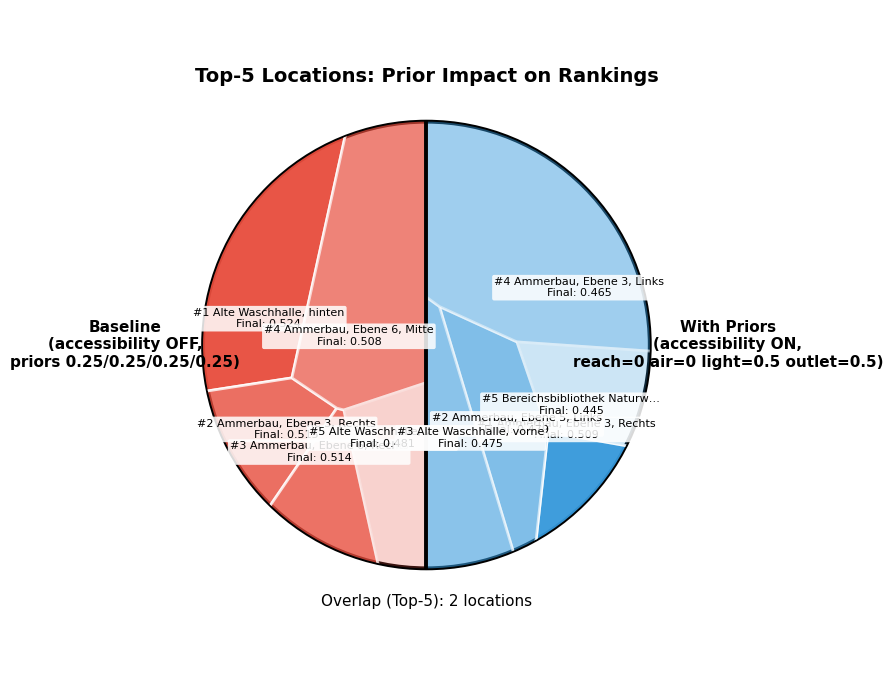

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Polygon
from scipy.spatial import Voronoi

from shapely.geometry import Polygon as SPoly, Point
from shapely.ops import unary_union

TOPK = 5
R = 1.0
SEED_LAYOUT = 42

# --- your exact lists (final only for ranking/coloring) ---
LEFT = [
    dict(rank=1, location="Alte Waschhalle, hinten", final=0.524),
    dict(rank=2, location="Ammerbau, Ebene 3, Rechts", final=0.515),
    dict(rank=3, location="Ammerbau, Ebene 6, Rechts", final=0.514),
    dict(rank=4, location="Ammerbau, Ebene 6, Mitte", final=0.508),
    dict(rank=5, location="Alte Waschhalle, vorne", final=0.481),
]
RIGHT = [
    dict(rank=1, location="Ammerbau, Ebene 3, Rechts", final=0.509),
    dict(rank=2, location="Ammerbau, Ebene 5, Links", final=0.479),
    dict(rank=3, location="Alte Waschhalle, vorne", final=0.475),
    dict(rank=4, location="Ammerbau, Ebene 3, Links", final=0.465),
    dict(rank=5, location="Bereichsbibliothek Naturwissenschaften, EG", final=0.445),
]

left_title = "Baseline\n(accessibility OFF,\npriors 0.25/0.25/0.25/0.25)"
right_title = "With Priors\n(accessibility ON,\nreach=0 air=0 light=0.5 outlet=0.5)"
main_title = "Top-5 Locations: Prior Impact on Rankings"

# Optional manual label overrides:
# label_pos_overrides_left = {"Alte Waschhalle, hinten": (-0.55, 0.20), ...}
label_pos_overrides_left = {}
label_pos_overrides_right = {}

# ----------------------------
# Helpers
# ----------------------------
def short(s, n=26):
    return s if len(s) <= n else s[:n-1] + "…"

def alpha_from(v, vmin, vmax):
    if vmax <= vmin + 1e-12:
        return 0.65
    t = (v - vmin) / (vmax - vmin)
    return 0.25 + 0.70 * t

def sample_seed_points(n, side, R, rng):
    pts = []
    while len(pts) < n:
        r = R * np.sqrt(rng.random())
        if side == "left":
            th = rng.uniform(np.pi/2, 3*np.pi/2)
        else:
            th = rng.uniform(-np.pi/2, np.pi/2)
        x, y = r*np.cos(th), r*np.sin(th)
        if side == "left" and x > -0.05:
            continue
        if side == "right" and x < 0.05:
            continue
        pts.append([x, y])
    return np.array(pts, dtype=float)

def mirror_point(p):
    return np.array([-p[0], p[1]])

def voronoi_finite_polygons_2d(vor, radius=10.0):
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_idx in enumerate(vor.point_region):
        region = vor.regions[region_idx]
        if region and all(v >= 0 for v in region):
            new_regions.append(region)
            continue

        ridges = all_ridges.get(p1, [])
        new_region = [v for v in region if v >= 0] if region else []

        for p2, v1, v2 in ridges:
            if v1 >= 0 and v2 >= 0:
                continue
            v = v1 if v1 >= 0 else v2

            t = vor.points[p2] - vor.points[p1]
            t = t / (np.linalg.norm(t) + 1e-12)
            n = np.array([-t[1], t[0]])

            midpoint = (vor.points[p1] + vor.points[p2]) / 2.0
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far = vor.vertices[v] + direction * radius

            new_vertices.append(far.tolist())
            new_region.append(len(new_vertices) - 1)

        new_regions.append(new_region)

    return new_regions, np.asarray(new_vertices, dtype=float)

def order_polygon(poly):
    c = poly.mean(axis=0)
    ang = np.arctan2(poly[:, 1] - c[1], poly[:, 0] - c[0])
    return poly[np.argsort(ang)]

def semicircle_shape(side, R=1.0, n=256):
    # build a polygon approximation of the semicircle for clipping/area
    if side == "left":
        angles = np.linspace(np.pi/2, 3*np.pi/2, n)
    else:
        angles = np.linspace(-np.pi/2, np.pi/2, n)
    arc = [(R*np.cos(a), R*np.sin(a)) for a in angles]
    # close along divider (x=0)
    if side == "left":
        pts = [(0, -R)] + arc + [(0, R)]
    else:
        pts = [(0, R)] + arc + [(0, -R)]
    return SPoly(pts)

def safe_label_point(seed_xy, side, pull=0.18):
    # pull toward center of that half to avoid edge collisions
    cx = -0.45 if side == "left" else 0.45
    cy = 0.0
    x, y = seed_xy
    return (x + pull*(cx-x), y + pull*(cy-y))

# ----------------------------
# Build seeds (mirroring overlaps by name)
# ----------------------------
left_names = [d["location"] for d in LEFT]
right_names = [d["location"] for d in RIGHT]
overlap = sorted(set(left_names) & set(right_names))
name_to_iL = {n:i for i,n in enumerate(left_names)}
name_to_iR = {n:i for i,n in enumerate(right_names)}

rng = np.random.default_rng(SEED_LAYOUT)
seedsL = sample_seed_points(TOPK, "left", R*0.90, rng)
seedsR = sample_seed_points(TOPK, "right", R*0.90, rng)

for name in overlap:
    iL = name_to_iL[name]
    iR = name_to_iR[name]
    seedsR[iR] = mirror_point(seedsL[iL])

# ----------------------------
# Build polygons and compute clipped areas
# ----------------------------
semiL = semicircle_shape("left", R)
semiR = semicircle_shape("right", R)

def build_cells(seeds, side):
    vor = Voronoi(seeds)
    regions, verts = voronoi_finite_polygons_2d(vor, radius=6.0)
    cells = []
    for i in range(len(seeds)):
        poly = order_polygon(verts[regions[i]])
        sp = SPoly(poly)
        clip = semiL if side=="left" else semiR
        clipped = sp.intersection(clip)
        area = clipped.area if not clipped.is_empty else 0.0
        cells.append((poly, clipped, area))
    return cells

cellsL = build_cells(seedsL, "left")
cellsR = build_cells(seedsR, "right")

print("LEFT area order (largest -> smallest):")
for i, (_, _, area) in sorted(enumerate(cellsL), key=lambda x: -x[1][2]):
    print(i, LEFT[i]["rank"], LEFT[i]["location"], "area=", round(area, 4))

print("\nRIGHT area order (largest -> smallest):")
for i, (_, _, area) in sorted(enumerate(cellsR), key=lambda x: -x[1][2]):
    print(i, RIGHT[i]["rank"], RIGHT[i]["location"], "area=", round(area, 4))

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_aspect("equal")
ax.axis("off")

left_clip = Wedge((0,0), R, 90, 270, facecolor="none", edgecolor="none")
right_clip = Wedge((0,0), R, -90, 90, facecolor="none", edgecolor="none")
ax.add_patch(left_clip); ax.add_patch(right_clip)

ax.add_patch(plt.Circle((0,0), R, fill=False, linewidth=2.8, edgecolor="black"))
ax.plot([0,0], [-R, R], linewidth=2.8, color="black")

ax.text(-R*1.35, 0, left_title, ha="center", va="center", fontsize=11, fontweight="bold")
ax.text(R*1.35, 0, right_title, ha="center", va="center", fontsize=11, fontweight="bold")
ax.text(0, R*1.20, main_title, ha="center", va="center", fontsize=14, fontweight="bold")

Lmin, Lmax = min(d["final"] for d in LEFT), max(d["final"] for d in LEFT)
Rmin, Rmax = min(d["final"] for d in RIGHT), max(d["final"] for d in RIGHT)

# Draw left polygons
for i, d in enumerate(LEFT):
    poly, clipped, area = cellsL[i]
    a = alpha_from(d["final"], Lmin, Lmax)
    patch = Polygon(poly, closed=True, facecolor="#e74c3c", edgecolor="white", linewidth=2.0, alpha=a)
    patch.set_clip_path(left_clip.get_path(), left_clip.get_transform())
    ax.add_patch(patch)

    # manual label position (override if you want)
    if d["location"] in label_pos_overrides_left:
        lx, ly = label_pos_overrides_left[d["location"]]
    else:
        lx, ly = safe_label_point(seedsL[i], "left", pull=0.22)

    ax.text(
        lx, ly,
        f"#{d['rank']} {short(d['location'])}\nFinal: {d['final']:.3f}",
        ha="center", va="center", fontsize=8,
        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.85),
        clip_on=True
    )

# Draw right polygons
for i, d in enumerate(RIGHT):
    poly, clipped, area = cellsR[i]
    a = alpha_from(d["final"], Rmin, Rmax)
    patch = Polygon(poly, closed=True, facecolor="#3498db", edgecolor="white", linewidth=2.0, alpha=a)
    patch.set_clip_path(right_clip.get_path(), right_clip.get_transform())
    ax.add_patch(patch)

    if d["location"] in label_pos_overrides_right:
        lx, ly = label_pos_overrides_right[d["location"]]
    else:
        lx, ly = safe_label_point(seedsR[i], "right", pull=0.22)

    ax.text(
        lx, ly,
        f"#{d['rank']} {short(d['location'])}\nFinal: {d['final']:.3f}",
        ha="center", va="center", fontsize=8,
        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.85),
        clip_on=True
    )

ax.text(0, -R*1.15, f"Overlap (Top-{TOPK}): {len(overlap)} locations", ha="center", va="center", fontsize=11)

ax.set_xlim(-1.6, 1.6)
ax.set_ylim(-1.5, 1.5)
plt.tight_layout()
plt.show()
